In [40]:
from sentinelhub import SHConfig
from dotenv import load_dotenv, find_dotenv
import os
load_dotenv(find_dotenv(filename=".env"), override=True)
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

CLIENT_ID = os.environ.get("CLIENT_ID")
CLIENT_SECRET = os.environ.get("CLIENT_SECRET")

config = SHConfig(  
    instance_id='',
    sh_client_id=CLIENT_ID,
    sh_client_secret=CLIENT_SECRET,
    sh_base_url='https://services.sentinel-hub.com',
    sh_auth_base_url='https://services.sentinel-hub.com',
   
)


In [41]:
betsiboka_coords_wgs84 = (-90.638065, 14.412347, -90.512924, 14.493799)
resolution = 60
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {betsiboka_size} pixels")


Image shape at 60 m resolution: (223, 153) pixels


In [42]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""


request_all_bands = SentinelHubRequest(
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-01", "2020-06-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

all_bands_response = request_all_bands.get_data()


# B12 Band sample

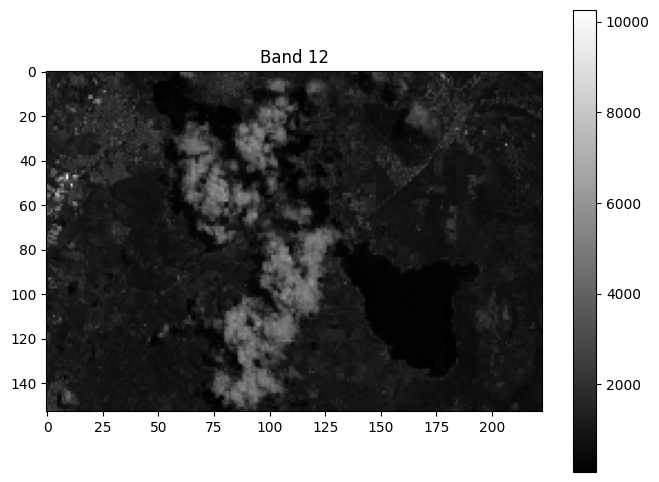

In [47]:

plt.figure(figsize=(8, 6))
plt.imshow(all_bands_response[0][:, :, 12], cmap='gray')
plt.title('Band 12')
plt.colorbar()
plt.show()

# All Bands sample

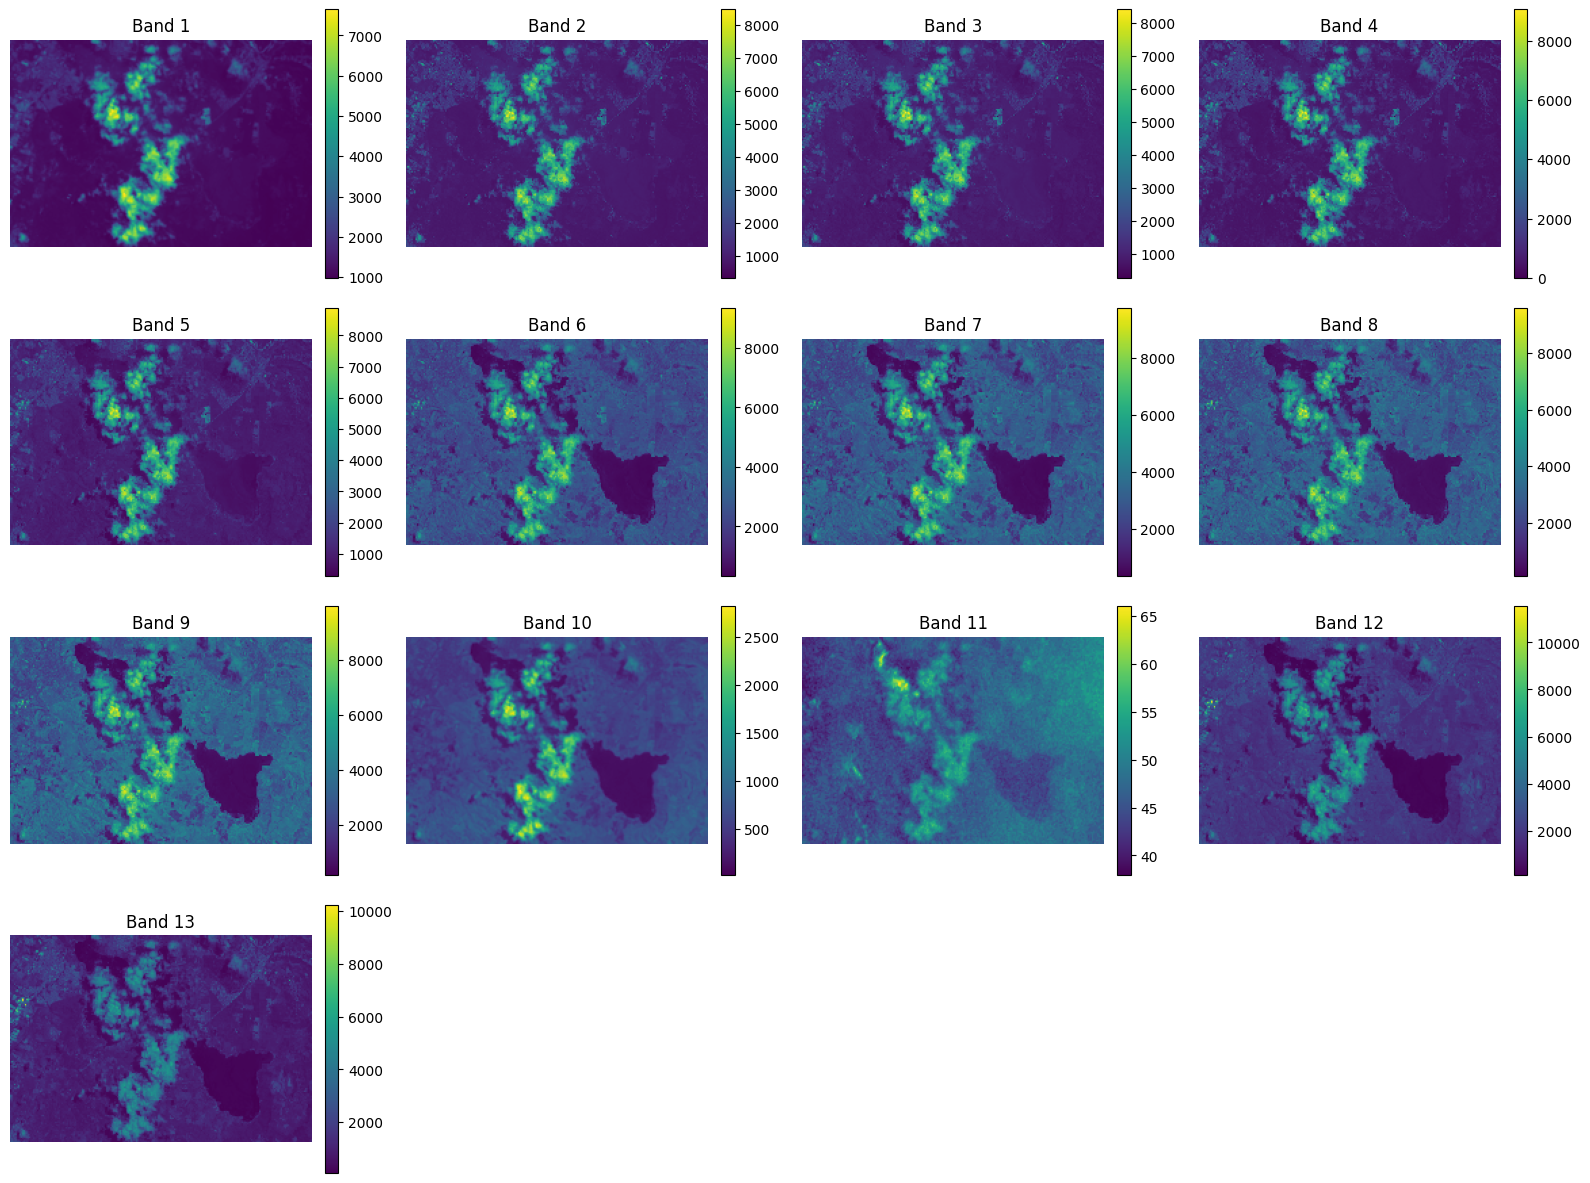

In [50]:
# Plot all 13 bands from all_bands_response[0] in a grid
import matplotlib.pyplot as plt
import numpy as np

bands_img = all_bands_response[0]  # shape: (height, width, 13)
n_bands = bands_img.shape[2]
n_cols = 4
n_rows = int(np.ceil(n_bands / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows))
axes = axes.flatten()

for i in range(n_bands):
    ax = axes[i]
    band = bands_img[:, :, i]
    im = ax.imshow(band)
    ax.set_title(f'Band {i+1}')
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Hide any unused subplots
for j in range(n_bands, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# RGB band sample

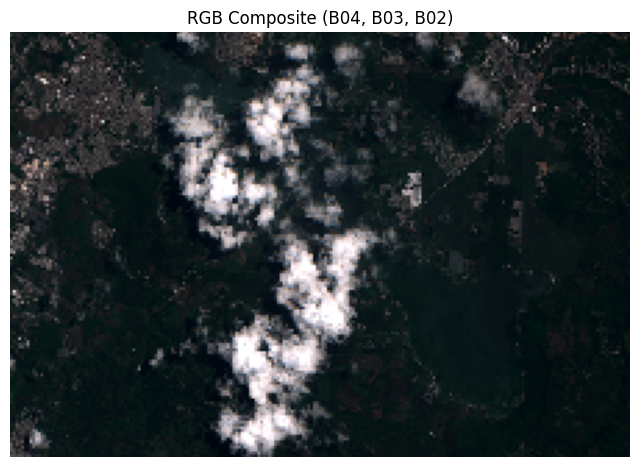

In [49]:
# Plot RGB composite (B04, B03, B02) from all_bands_response[0]
import matplotlib.pyplot as plt
import numpy as np

bands_img = all_bands_response[0]  # shape: (height, width, 13)
# Sentinel-2: B04=red (index 3), B03=green (index 2), B02=blue (index 1)
rgb = bands_img[:, :, [3, 2, 1]].astype(float)

# Normalize for display (simple min-max normalization)
rgb_min = np.percentile(rgb, 1)
rgb_max = np.percentile(rgb, 99)
rgb = np.clip((rgb - rgb_min) / (rgb_max - rgb_min), 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title('RGB Composite (B04, B03, B02)')
plt.axis('off')
plt.show()